In [29]:
!pip install folktables

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
!rm -rf ./RAI-summer-stability

In [62]:
!git clone https://github.com/FalaahArifKhan/RAI-summer-stability.git
!ls

Cloning into 'RAI-summer-stability'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 81 (delta 30), reused 45 (delta 11), pack-reused 0
Unpacking objects: 100% (81/81), done.
data  RAI-summer-stability  sample_data


In [31]:
!git clone https://github.com/FalaahArifKhan/RAI-summer-stability.git
!ls

fatal: destination path 'RAI-summer-stability' already exists and is not an empty directory.
data  RAI-summer-stability  sample_data


In [32]:
!ls ./RAI-summer-stability/utils

model_tuning_utils.py  __pycache__


In [33]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [34]:
import sys
import sklearn
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pprint import pprint

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

# from utils.model_tuning_utils import test_ML_models
import importlib
stability = importlib.import_module("RAI-summer-stability.utils.model_tuning_utils")

In [35]:
%matplotlib inline

plt.style.use('mpl20')
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['figure.figsize'] = 15, 5

import warnings
warnings.filterwarnings('ignore')

### Python & Library Versions

In [36]:
versions = ( ("matplotlib", matplotlib.__version__),
             ("numpy", np.__version__),
             ("pandas", pd.__version__),
             ("sklearn", sklearn.__version__),
             ("seaborn", sns.__version__)
             )

print(sys.version, "\n")
print("library" + " " * 4 + "version")
print("-" * 18)

for tup1, tup2 in versions:
    print("{:11} {}".format(tup1, tup2))


3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0] 

library    version
------------------
matplotlib  3.2.2
numpy       1.21.6
pandas      1.3.5
sklearn     1.0.2
seaborn     0.11.2


### Read a dataset

In [37]:
from folktables import ACSDataSource, ACSEmployment

data_source = ACSDataSource(survey_year='2016', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA", "FL"], download=True)
features, label, group = ACSEmployment.df_to_numpy(acs_data)

### Data Pre-processing

In [38]:
ACSEmployment.target

'ESR'

In [39]:
ACSEmployment.features

['AGEP',
 'SCHL',
 'MAR',
 'RELP',
 'DIS',
 'ESP',
 'CIT',
 'MIG',
 'MIL',
 'ANC',
 'NATIVITY',
 'DEAR',
 'DEYE',
 'DREM',
 'SEX',
 'RAC1P']

In [40]:
features.shape, acs_data.shape

((572863, 16), (572863, 284))

In [41]:
# Create pandas datafrane with features and label column
full_df = acs_data[ACSEmployment.features + [ACSEmployment.target]].copy()
full_df.head()

,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,RAC1P,ESR
0,68,20.0,1,0,2,NaN,4,1.0,4.0,1,2,2,2,2.0,2,9,6.0
1,75,18.0,1,1,2,NaN,4,1.0,2.0,1,2,2,2,2.0,1,9,6.0
2,50,19.0,1,0,2,NaN,1,1.0,4.0,1,1,2,2,2.0,2,9,1.0
3,49,16.0,1,1,2,NaN,1,1.0,4.0,1,1,2,2,2.0,1,1,1.0
4,22,18.0,5,2,2,NaN,1,1.0,4.0,1,1,2,2,2.0,1,9,3.0


In [42]:
# Convert label column to binary format
full_df['LABEL_ESR'] = ACSEmployment.target_transform(full_df[ACSEmployment.target])
full_df.drop([ACSEmployment.target], axis=1, inplace=True)

In [43]:
full_df['AGEP'].describe()

count    572863.000000
mean         41.568450
std          23.587085
min           0.000000
25%          22.000000
50%          42.000000
75%          60.000000
max          95.000000
Name: AGEP, dtype: float64

In [44]:
full_df.isnull().sum()

AGEP              0
SCHL          16509
MAR               0
RELP              0
DIS               0
ESP          465075
CIT               0
MIG            5326
MIL          107124
ANC               0
NATIVITY          0
DEAR              0
DEYE              0
DREM          27974
SEX               0
RAC1P             0
LABEL_ESR         0
dtype: int64

In [45]:
full_df.fillna(0, inplace = True)
full_df.isnull().sum()

AGEP         0
SCHL         0
MAR          0
RELP         0
DIS          0
ESP          0
CIT          0
MIG          0
MIL          0
ANC          0
NATIVITY     0
DEAR         0
DEYE         0
DREM         0
SEX          0
RAC1P        0
LABEL_ESR    0
dtype: int64

### Data Profiling

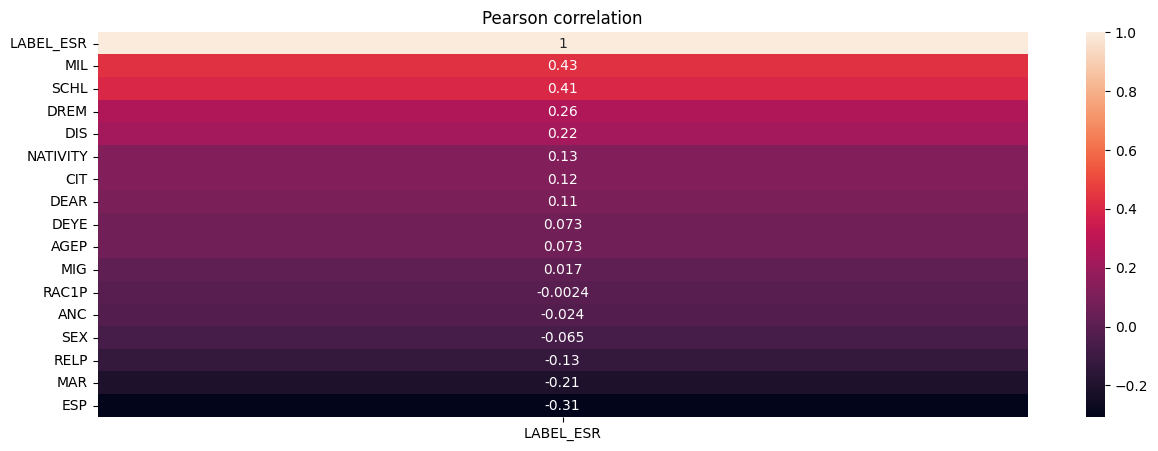

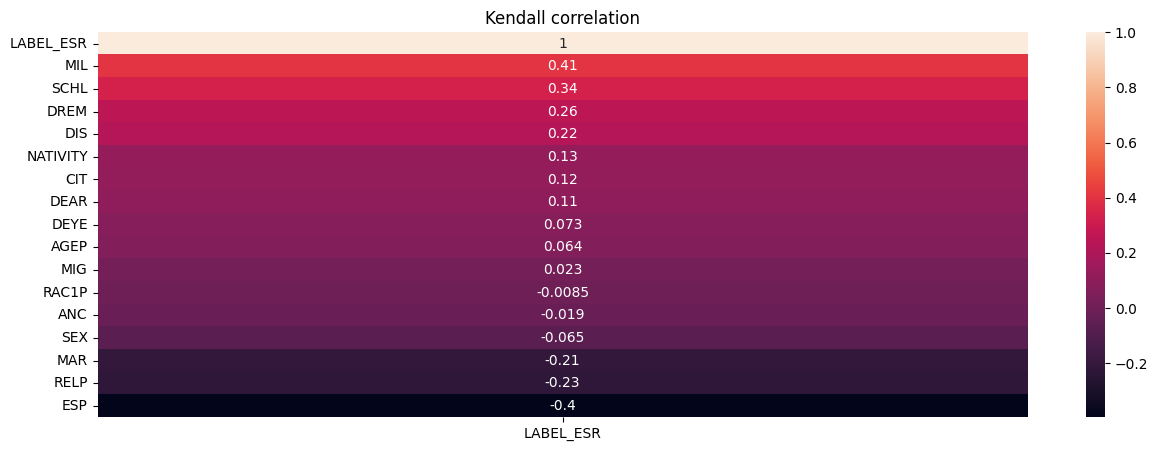

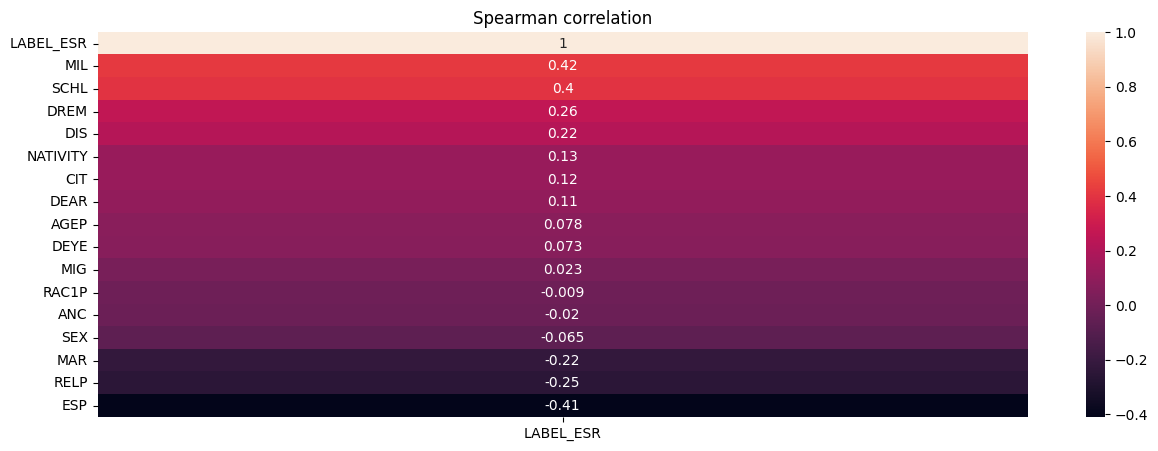

In [46]:
# Look at the feature correlation with 'LABEL_ESR' column
for method in ['pearson', 'kendall', 'spearman']:
    ax = plt.axes()
    sns.heatmap(
        full_df.corr(method=method)[['LABEL_ESR']]\
            .sort_values(by='LABEL_ESR', ascending=False),
        ax=ax,
        annot=True
    )
    ax.set_title(f'{method.capitalize()} correlation')
    plt.show()


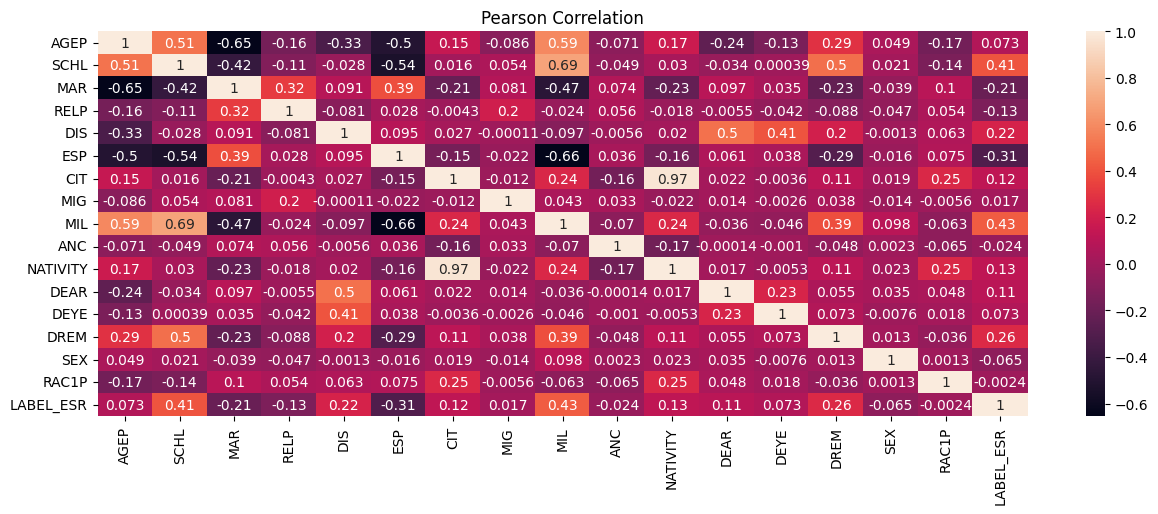

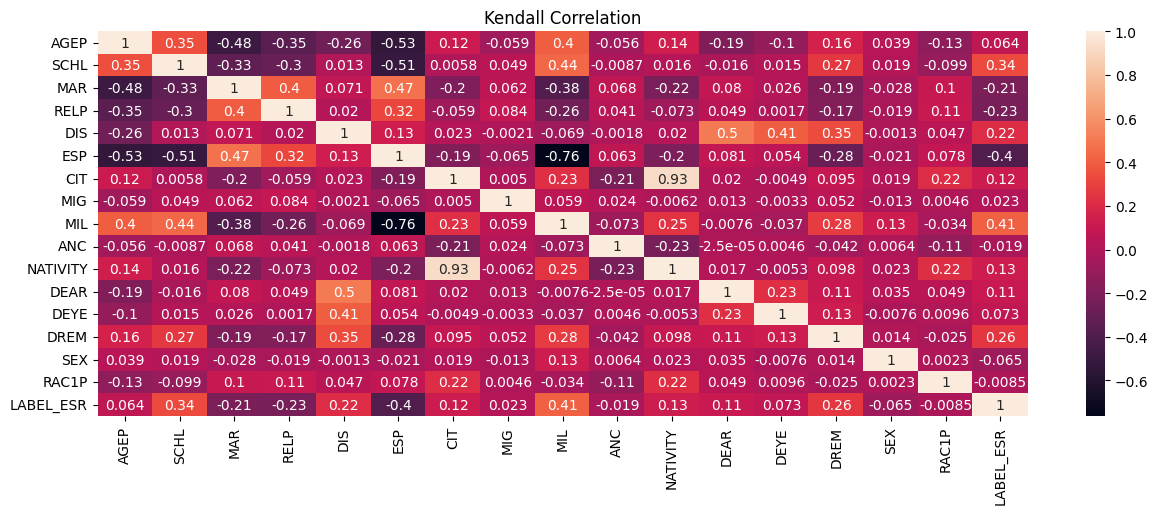

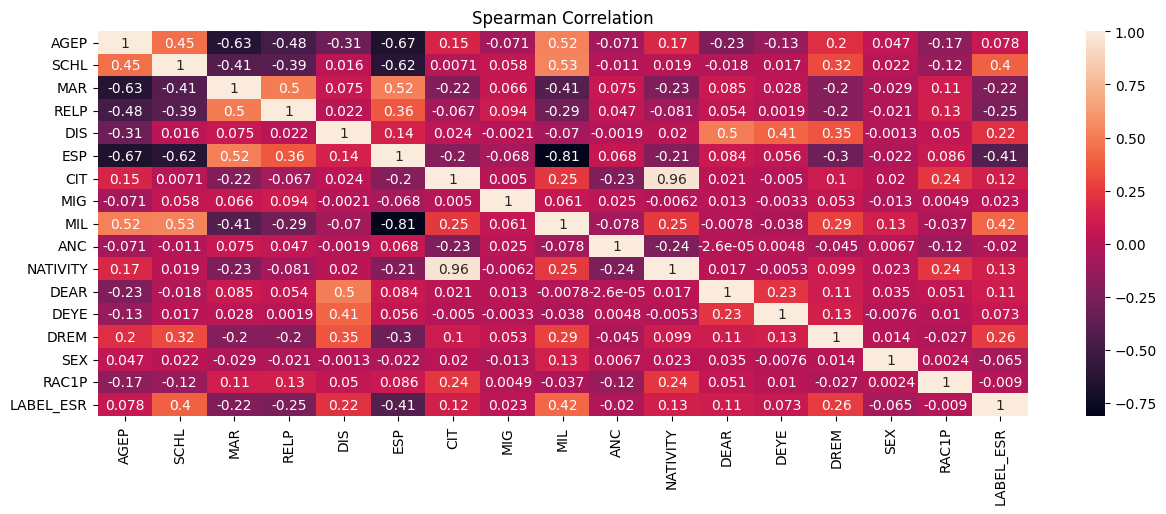

In [47]:
# Look at correlations among features
for method in ['pearson', 'kendall', 'spearman']:
    ax = plt.axes()
    sns.heatmap(full_df.corr(method=method), ax=ax, annot=True)
    ax.set_title(f'{method.capitalize()} Correlation')
    plt.show()


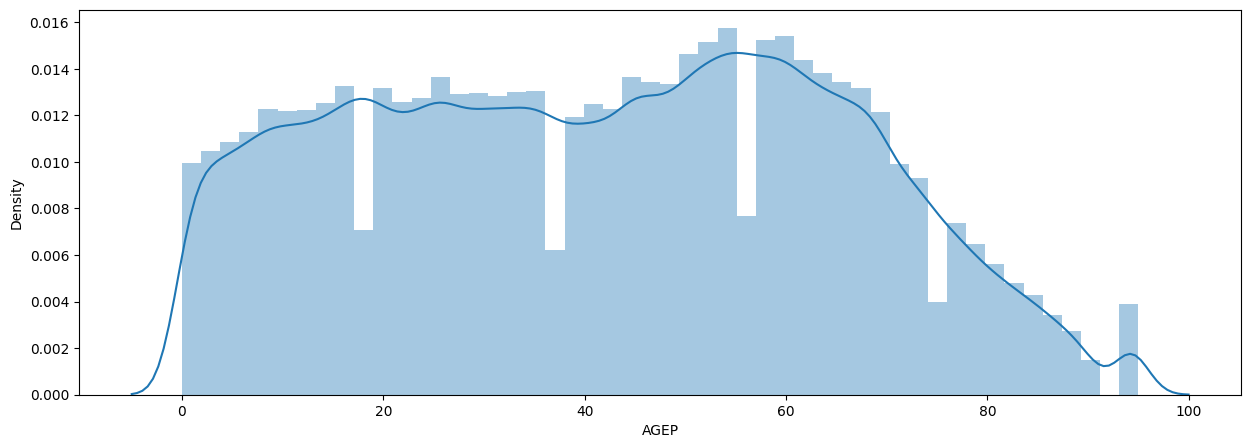

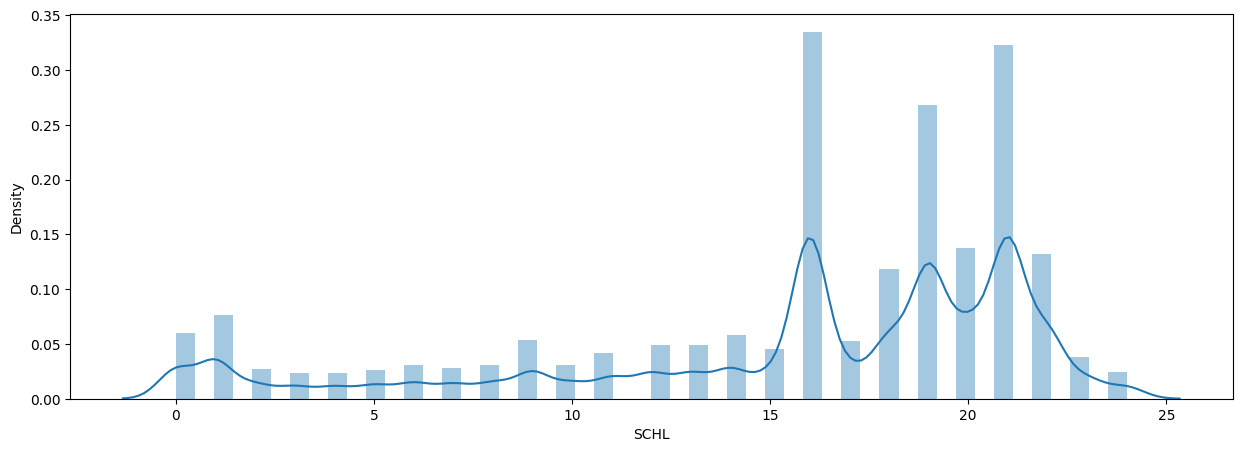

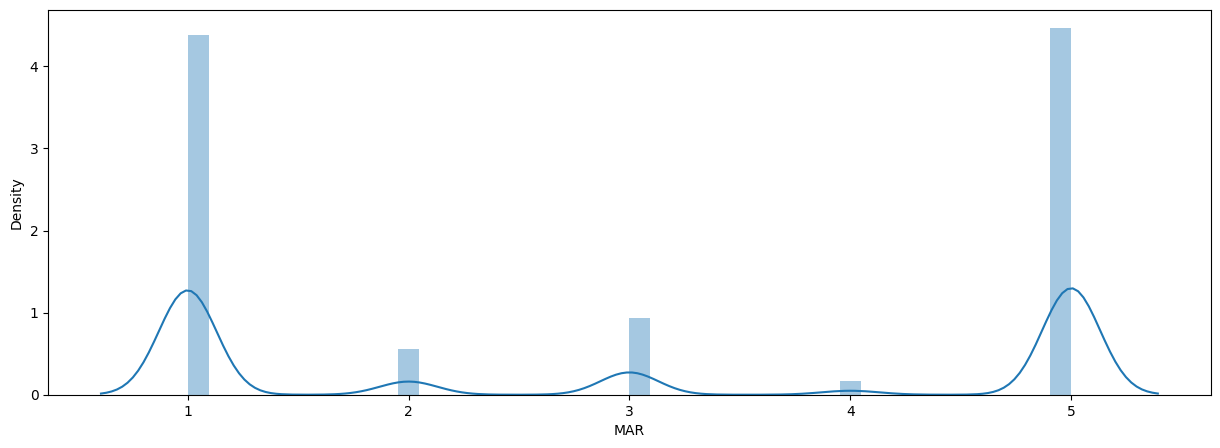

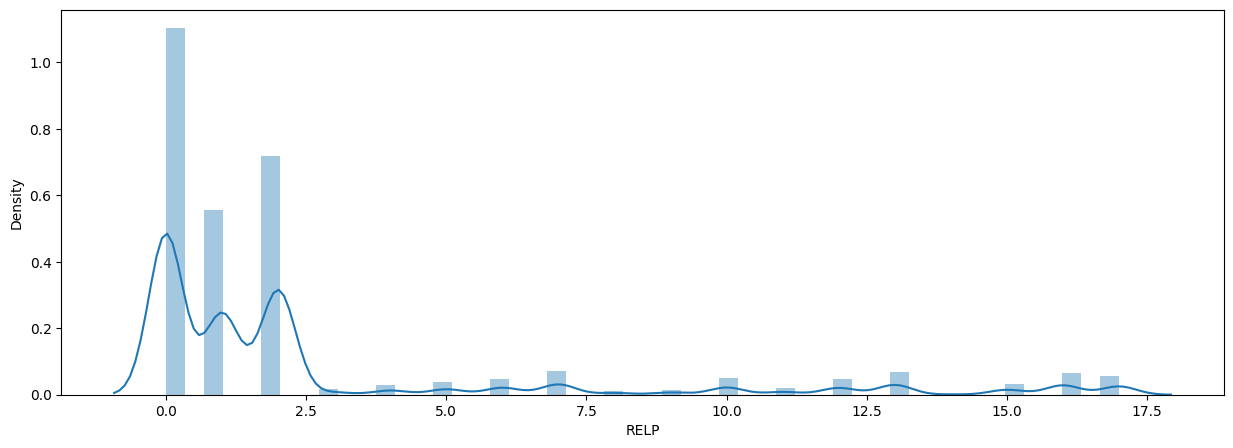

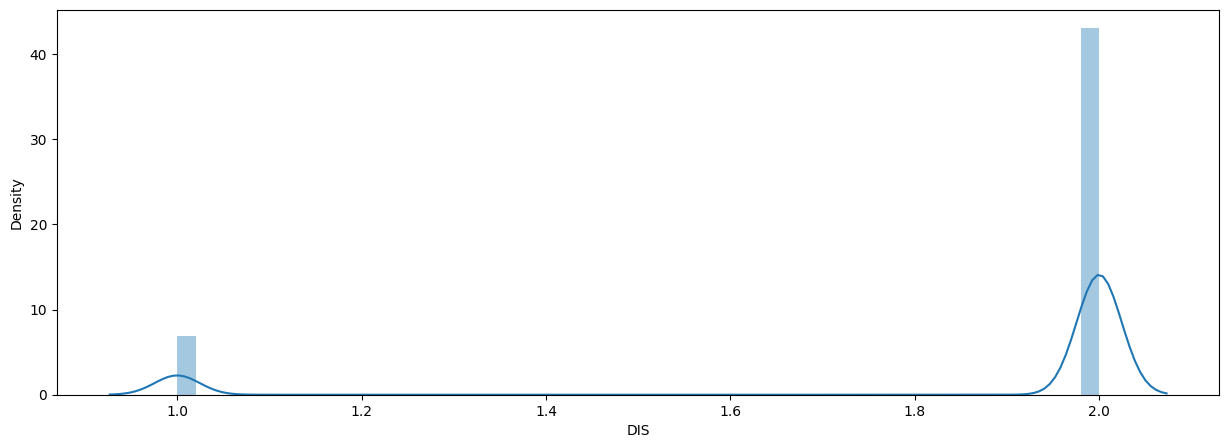

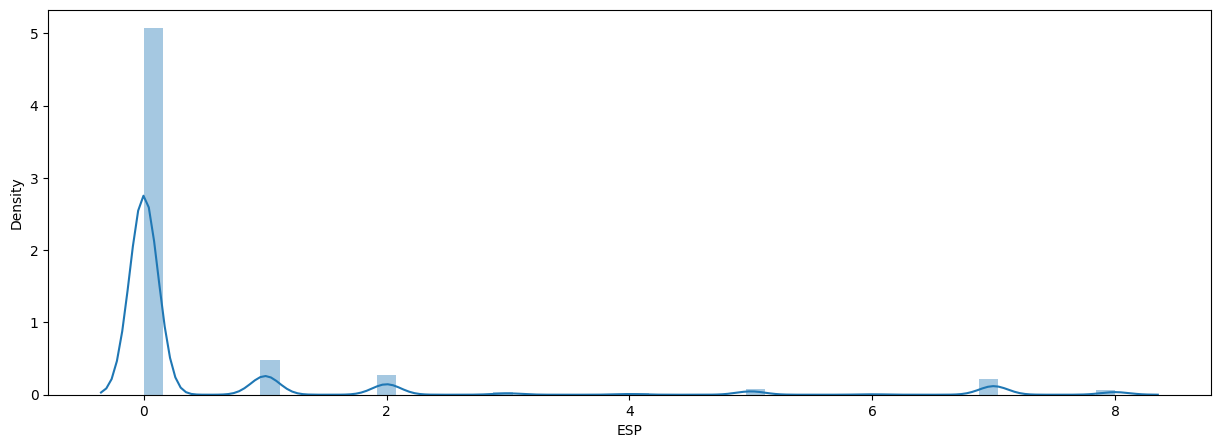

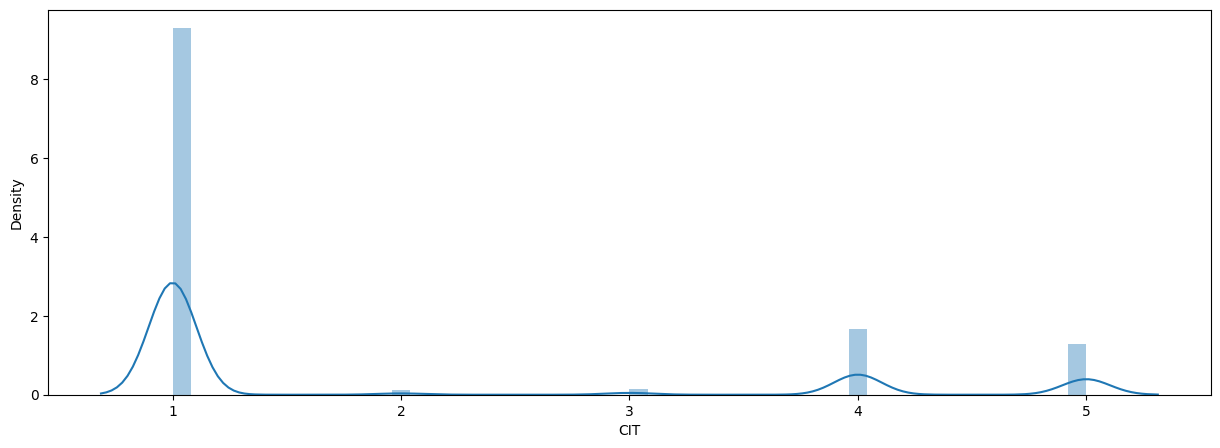

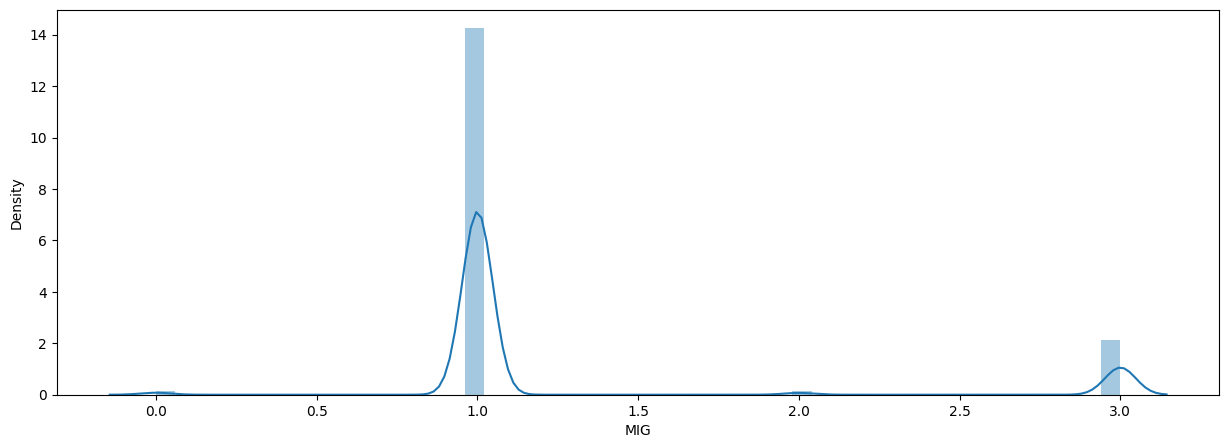

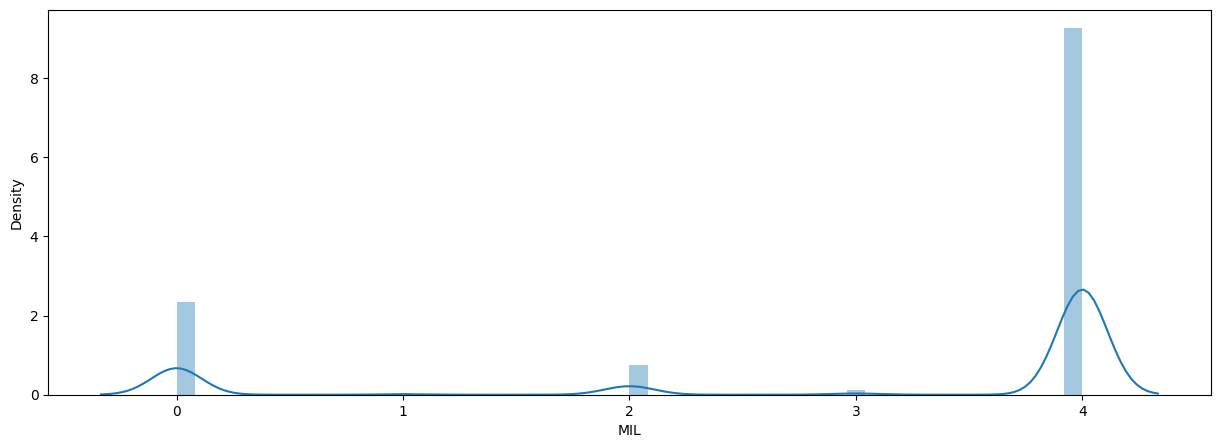

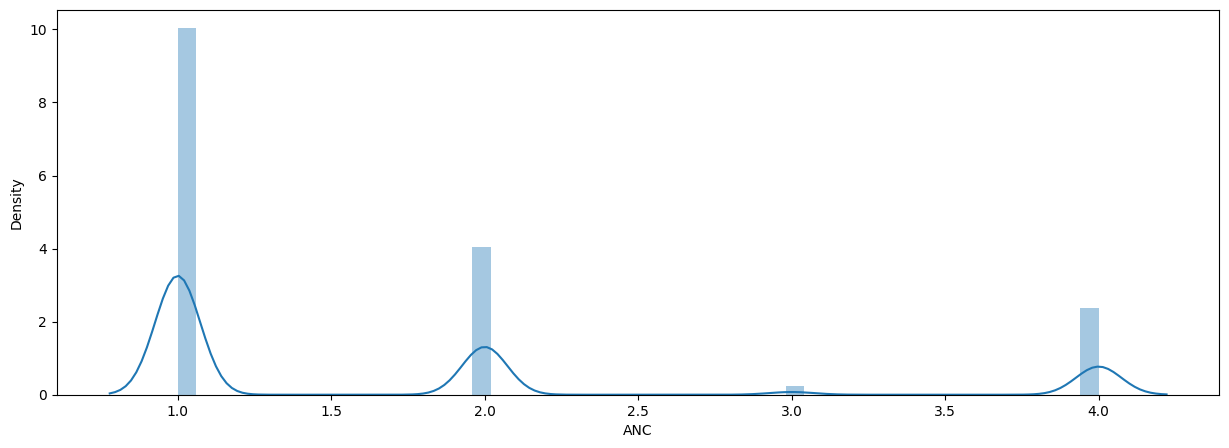

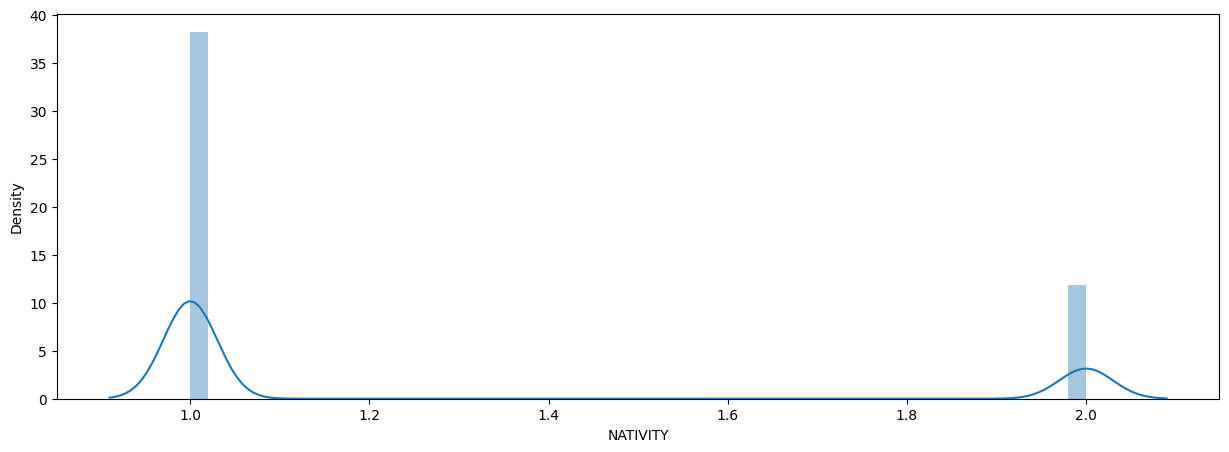

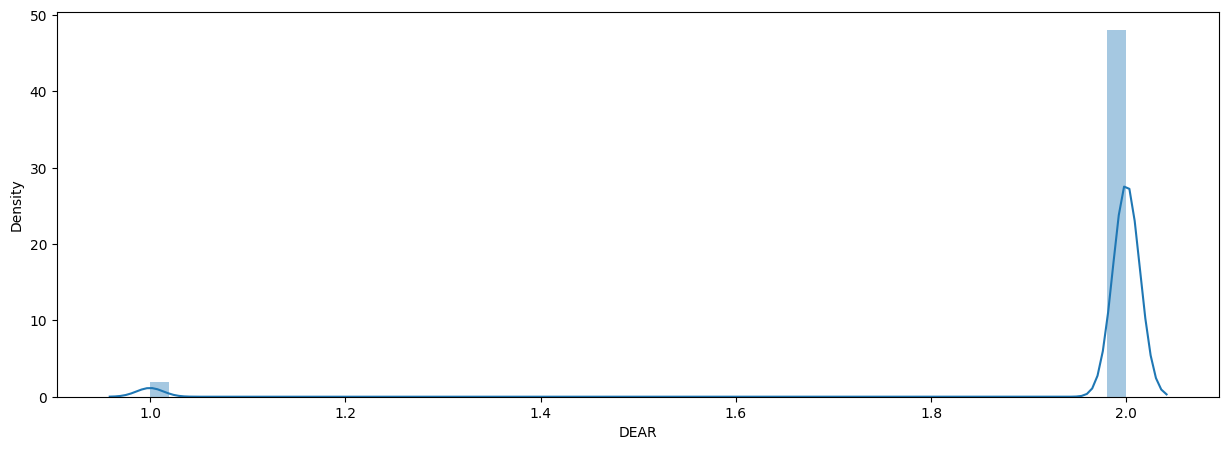

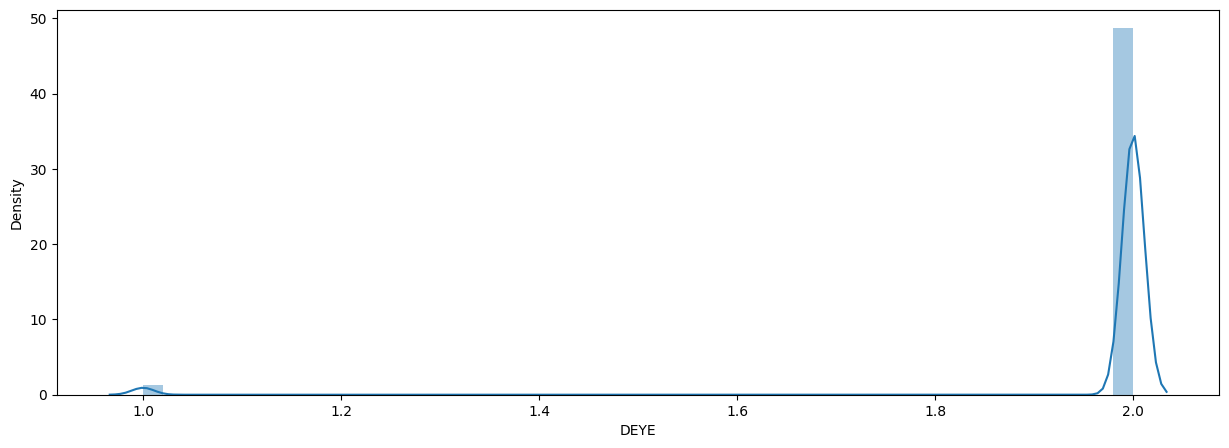

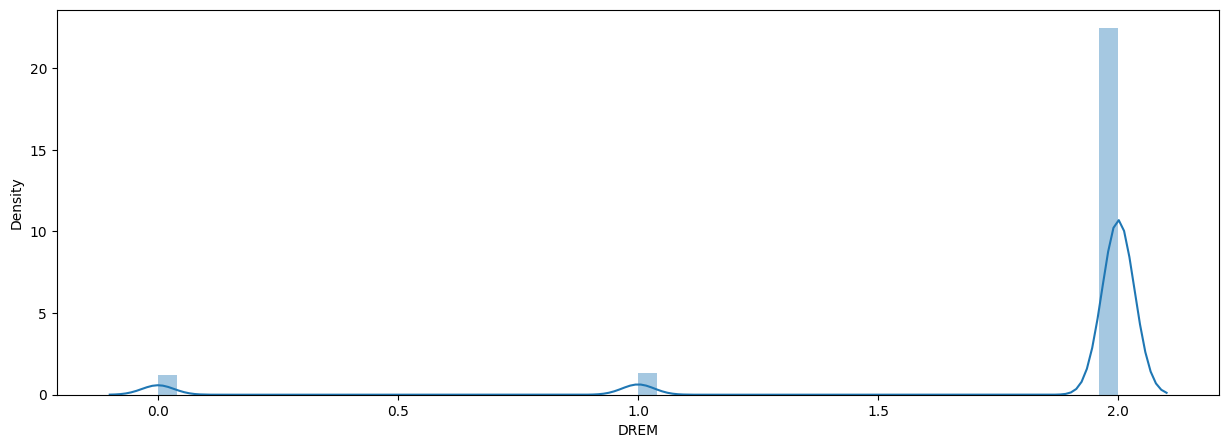

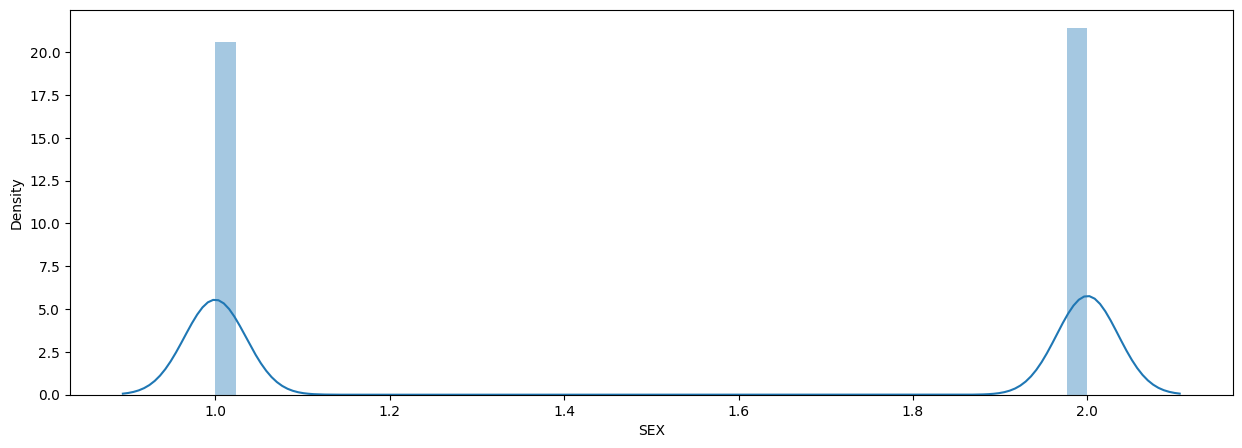

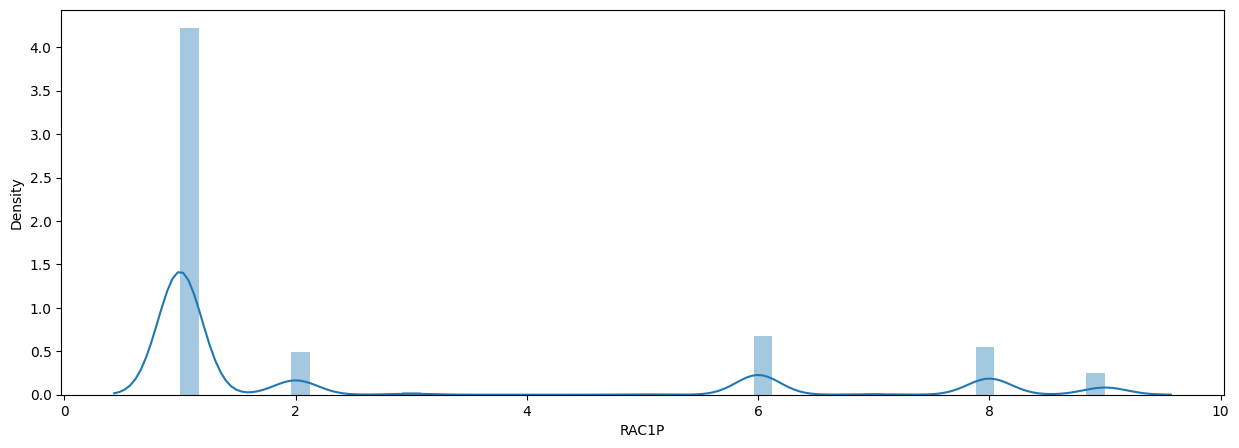

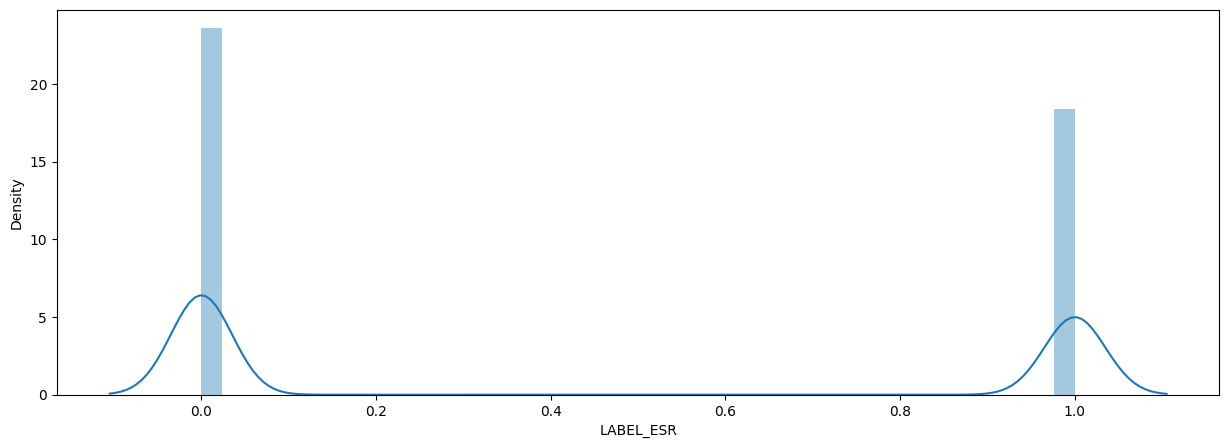

In [48]:
# Look at densities of each column
for column in full_df.columns:
    plt.figure()
    sns.distplot(full_df[column])

### Analyze Feature Importance

In [49]:
SEED = 42
features_df = full_df.drop('LABEL_ESR', axis=1, inplace=False)
target_df = full_df['LABEL_ESR']
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(features_df, target_df, test_size=0.2, random_state=SEED)
X_train_full.shape, X_test_full.shape

((458290, 16), (114573, 16))

Text(0.5, 0, 'Random Forest Feature Importance')

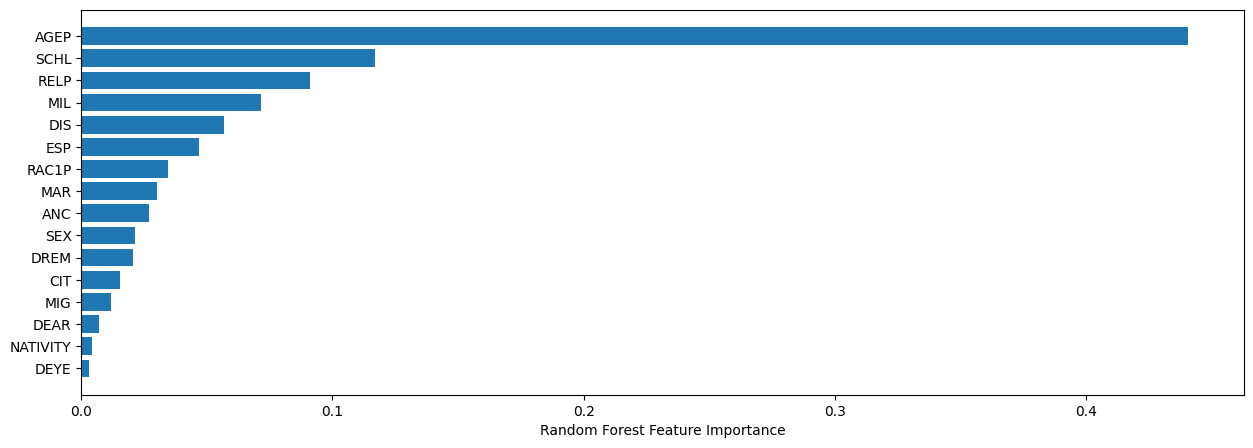

In [50]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train_full, y_train_full)

sorted_idx = rf.feature_importances_.argsort()
plt.barh(features_df.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### Train a baseline model

In [51]:
# Create a feature dataframe based on the feature correlation with 'LABEL_ESR' and feature importance
feature_cols = ['MIL', 'DIS', 'ESP', 'MAR', 'RELP', 'ANC']
features_df = pd.get_dummies(full_df[feature_cols], columns=feature_cols)
features_df['AGEP'] = full_df['AGEP']
features_df['SCHL'] = full_df['SCHL']
target_df = full_df['LABEL_ESR']
features_df.head()

,MIL_0.0,MIL_1.0,MIL_2.0,MIL_3.0,MIL_4.0,DIS_1,DIS_2,ESP_0.0,ESP_1.0,ESP_2.0,...,RELP_14,RELP_15,RELP_16,RELP_17,ANC_1,ANC_2,ANC_3,ANC_4,AGEP,SCHL
0,0,0,0,0,1,0,1,1,0,0,...,0,0,0,0,1,0,0,0,68,20.0
1,0,0,1,0,0,0,1,1,0,0,...,0,0,0,0,1,0,0,0,75,18.0
2,0,0,0,0,1,0,1,1,0,0,...,0,0,0,0,1,0,0,0,50,19.0
3,0,0,0,0,1,0,1,1,0,0,...,0,0,0,0,1,0,0,0,49,16.0
4,0,0,0,0,1,0,1,1,0,0,...,0,0,0,0,1,0,0,0,22,18.0


In [52]:
features_df.columns

Index(['MIL_0.0', 'MIL_1.0', 'MIL_2.0', 'MIL_3.0', 'MIL_4.0', 'DIS_1', 'DIS_2',
       'ESP_0.0', 'ESP_1.0', 'ESP_2.0', 'ESP_3.0', 'ESP_4.0', 'ESP_5.0',
       'ESP_6.0', 'ESP_7.0', 'ESP_8.0', 'MAR_1', 'MAR_2', 'MAR_3', 'MAR_4',
       'MAR_5', 'RELP_0', 'RELP_1', 'RELP_2', 'RELP_3', 'RELP_4', 'RELP_5',
       'RELP_6', 'RELP_7', 'RELP_8', 'RELP_9', 'RELP_10', 'RELP_11', 'RELP_12',
       'RELP_13', 'RELP_14', 'RELP_15', 'RELP_16', 'RELP_17', 'ANC_1', 'ANC_2',
       'ANC_3', 'ANC_4', 'AGEP', 'SCHL'],
      dtype='object')

In [53]:
X_train, X_test, y_train, y_test = train_test_split(features_df, target_df, test_size=0.2, random_state=SEED)
X_train.shape, X_test.shape

((458290, 45), (114573, 45))

In [54]:
n_folds = 3
samples_per_fold = len(y_test)
best_results_df = pd.DataFrame(columns=('Dataset_Name', 'Model_Name', 'F1_Score',
                                   'Accuracy_Score',
                                   'Model_Best_Params', 'Model_Pred'))

In [65]:
config_models = [
    {
        'model_name': 'GaussianNB',
        'model': GaussianNB(),
        'params': {
            'var_smoothing': [1e-9, 1e-5]
        }
    },
    # {
    #     'model_name': 'SVC',
    #     'model': SVC(random_state=SEED),
    #     'params': {
    #         'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    #     }
    # },
    {
        'model_name': 'LogisticRegression',
        'model': LogisticRegression(random_state=SEED),
        'params': {
            'penalty': ['l1', 'l2'],
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
            'max_iter': range(50, 251, 50),
        }
    },
    {
        'model_name': 'RandomForestClassifier',
        'model': RandomForestClassifier(random_state=SEED),
        'params': {
            "bootstrap": [True, False],
            "max_depth": [3, 4, 6, 10],
            "n_estimators": [5 * i for i in range(1, 7)],
            "max_features": [0.6]
        }
    },
    {
        'model_name': 'DecisionTreeClassifier',
        'model': DecisionTreeClassifier(random_state=SEED),
        'params': {
            "max_depth": [2, 3, 4, 6, 10],
            "max_features": [0.6, 'sqrt'],
            "criterion": ["gini", "entropy"]
        }
    },
    # For XGBoost parameters tuning we used this article --
    # https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
    {
        'model_name': 'XGBClassifier',
        'model': XGBClassifier(random_state=SEED),
        'params': {
            'learning_rate': [0.1, 0.01],
            'n_estimators': [100, 200],
            'max_depth': range(3, 10, 2),
            'objective':  ['binary:logistic'],
        }
    }
]

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Tuning for GaussianNB is finished
####################  Folktables [LA]  ####################
Test model:  GaussianNB
Test model parameters:
{'var_smoothing': 1e-05}

              precision    recall  f1-score   support

       False      0.927     0.525     0.670     64299
        True      0.609     0.947     0.741     50274

    accuracy                          0.710    114573
   macro avg      0.768     0.736     0.706    114573
weighted avg      0.787     0.710     0.701    114573



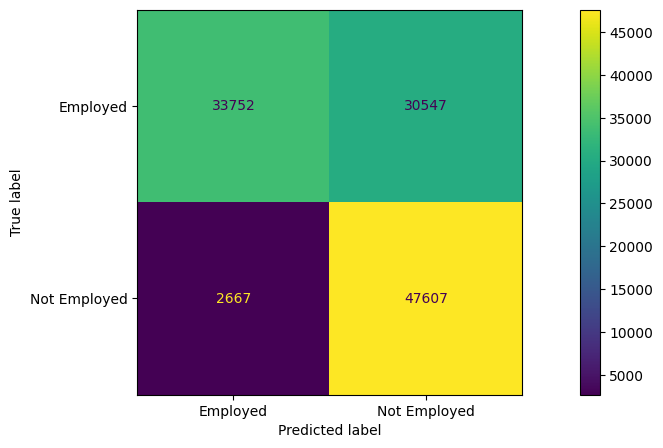

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Tuning for LogisticRegression is finished
####################  Folktables [LA]  ####################
Test model:  LogisticRegression
Test model parameters:
{'max_iter': 200, 'penalty': 'l2', 'solver': 'lbfgs'}

              precision    recall  f1-score   support

       False      0.857     0.758     0.805     64299
        True      0.731     0.838     0.781     50274

    accuracy                          0.793    114573
   macro avg      0.794     0.798     0.793    114573
weighted avg      0.802     0.793     0.794    114573



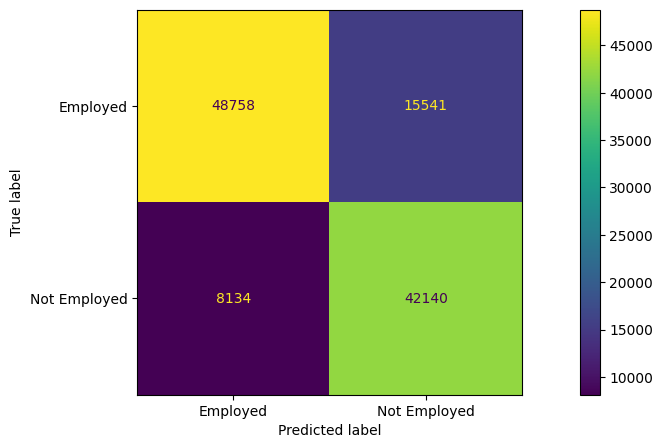

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Tuning for RandomForestClassifier is finished
####################  Folktables [LA]  ####################
Test model:  RandomForestClassifier
Test model parameters:
{'bootstrap': True, 'max_depth': 10, 'max_features': 0.6, 'n_estimators': 30}

              precision    recall  f1-score   support

       False      0.883     0.771     0.823     64299
        True      0.748     0.869     0.804     50274

    accuracy                          0.814    114573
   macro avg      0.815     0.820     0.814    114573
weighted avg      0.824     0.814     0.815    114573



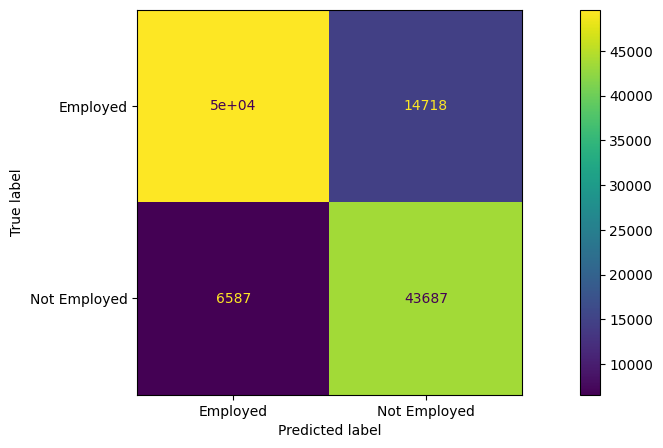

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Tuning for DecisionTreeClassifier is finished
####################  Folktables [LA]  ####################
Test model:  DecisionTreeClassifier
Test model parameters:
{'criterion': 'gini', 'max_depth': 10, 'max_features': 0.6}

              precision    recall  f1-score   support

       False      0.876     0.777     0.823     64299
        True      0.751     0.859     0.801     50274

    accuracy                          0.813    114573
   macro avg      0.813     0.818     0.812    114573
weighted avg      0.821     0.813     0.814    114573



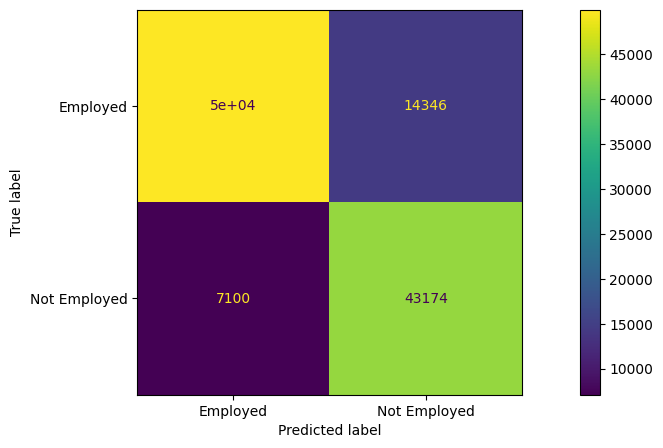

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Tuning for XGBClassifier is finished
####################  Folktables [LA]  ####################
Test model:  XGBClassifier
Test model parameters:
{'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 200,
 'objective': 'binary:logistic'}

              precision    recall  f1-score   support

       False      0.880     0.775     0.824     64299
        True      0.751     0.865     0.804     50274

    accuracy                          0.815    114573
   macro avg      0.815     0.820     0.814    114573
weighted avg      0.823     0.815     0.815    114573



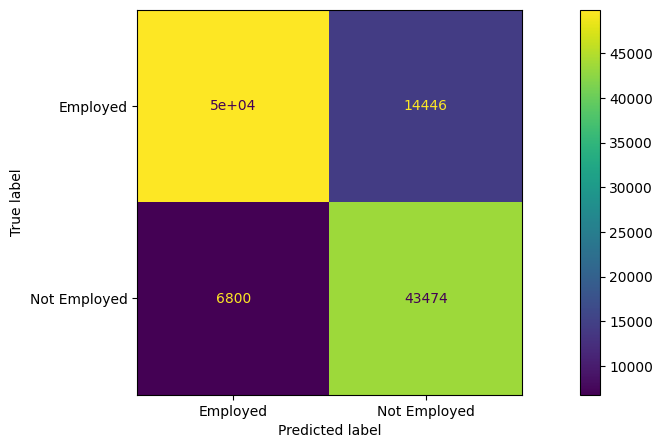

,Dataset_Name,Model_Name,F1_Score,Accuracy_Score,Model_Best_Params
0,Folktables [LA],GaussianNB,0.705804,0.710106,{'var_smoothing': 1e-05}
1,Folktables [LA],LogisticRegression,0.792671,0.793363,"{'max_iter': 200, 'penalty': 'l2', 'solver': '..."
2,Folktables [LA],RandomForestClassifier,0.813555,0.814049,"{'bootstrap': True, 'max_depth': 10, 'max_feat..."
3,Folktables [LA],DecisionTreeClassifier,0.812160,0.812818,"{'criterion': 'gini', 'max_depth': 10, 'max_fe..."
4,Folktables [LA],XGBClassifier,0.813987,0.814564,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti..."


In [66]:
ML_results_df = stability.test_ML_models(best_results_df, config_models, n_folds, samples_per_fold,
                                         X_train, y_train, X_test, y_test, "Folktables [LA]", show_plots=True, debug_mode=True)
ML_results_df

In [67]:
for index, row in ML_results_df.iterrows():
  print(f'\n\nModel name: {row["Model_Name"]}')
  pprint(row['Model_Best_Params'])



Model name: GaussianNB
{'var_smoothing': 1e-05}


Model name: LogisticRegression
{'max_iter': 200, 'penalty': 'l2', 'solver': 'lbfgs'}


Model name: RandomForestClassifier
{'bootstrap': True, 'max_depth': 10, 'max_features': 0.6, 'n_estimators': 30}


Model name: DecisionTreeClassifier
{'criterion': 'gini', 'max_depth': 10, 'max_features': 0.6}


Model name: XGBClassifier
{'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 200,
 'objective': 'binary:logistic'}
